## Track upwelled water in no canyon cases

Are my functions for HCW not working or why can't I find any upwelled water in the no-canyon Astoria, no-canyon Barkley and Barkley cases?

Astoria and Barkley's incoming U is smaller than in the original canyon (0.37 ms$^{-1}$). Astoria's (0.28 ms$^{-1}$) is lower than Barkley's (0.32 ms$^{-1}$). (see Notebook: Circulation_Astoria_Barkley)

In [1]:
import cmocean as cmo
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
import canyon_tools.readout_tools as rout
import canyon_tools.savitzky_golay as sg
import canyon_tools.metrics_tools as mtt 

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [3]:
sns.set_style('dark')

In [4]:
def calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4):
    """-----------------------------------------------------------------------------
    calc_rho calculates the density using a linear equation of state.
    
    INPUT:
    RhoRef : reference density at the same z as T and S slices. Can be a scalar or a 
             vector, depending on the size of T and S.
    T, S   : should be at least 2D arrays in coordinate order (..., Y , X ) 
    alpha = 2.0E-4 # 1/degC, thermal expansion coefficient
    beta = 7.4E-4, haline expansion coefficient
    OUTPUT:
    rho - Density [...,ny,nx]
    -----------------------------------------------------------------------------"""
    
    #Linear eq. of state 
    rho = RhoRef*(np.ones(np.shape(T)) - alpha*(T[...,:,:]) + beta*(S[...,:,:]))
    return rho

def call_rho(state,t,yslice,xslice):
    T = state.Temp.isel(T=t,Y=yslice,X=xslice)
    S = state.S.isel(T=t,Y=yslice,X=xslice)
    rho = calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4)
    return(rho) 

def mask2DCanyon(bathy, sbdepth=-152.5):
    '''Mask out the canyon from the shelf.
    bathy : depths 2D array from the grid file
    sbdepth: shelf depth, always negative float 
    Returns mask'''
    
    bathyMasked = np.ma.masked_less(-bathy, sbdepth)
    return(bathyMasked.mask)

def BottomConc(Tr, hfac, ra, bathy, nz, sbdepth=-152.5):
    '''Tr: Tracer field (nt,nz,ny,nx)
       hfac: fraction of open cell at center (nz,ny,nx)
       ra: array of cell horizontal areas (ny,nx)
       bathy : depths 2D array from the grid file (ny,nx)
       sbdepth: shelf break depth (negative value)
       
       RETURNS:
       ConcArea = concentration at cell closest to bottom times its area (nt,ny,nx)
       Conc = cocnetration near bottom (nt,ny,nx)'''
    
    ConcArea = np.empty((360,616))
    Conc = np.empty((360,616))
    ConcFiltered = np.empty((360,616))
    Area = np.empty((360,616))
    BottomInd = np.argmax(hfac[::-1,:,:]>0.0,axis=0) # start looking for first no-land cell from the bottom up.
    BottomInd = np.ones(np.shape(BottomInd))*nz - BottomInd # Get index of unreversed z axis
    
    for j in range(616):
        for i in range(360):
            TrBottom = Tr[int(BottomInd[i,j]),i,j]
            ConcArea[i,j] = TrBottom*ra[i,j]
            Conc[i,j] = TrBottom
            Area[i,j] = ra[i,j]
                    
        # Filter step noise
        ConcFiltered[:,j] = sg.savitzky_golay(Conc[:,j], 7,3) 
                
    maskShelf = mask2DCanyon(bathy, sbdepth)
    maskShelf = np.expand_dims(maskShelf,0) # expand along time dimension
    maskShelf = maskShelf + np.zeros(Conc.shape)
    
    return (ConcArea,
            np.ma.masked_array(ConcFiltered, mask=maskShelf),
            Area,
           )

def BottomAnom(Tr, hfac, ra, bathy,nz, sbdepth=-152.5):
    '''Tr: Tracer field-Tr field no canyon (nt,nz,ny,nx)
       hfac: fraction of open cell at center (nz,ny,nx)
       ra: array of cell horizontal areas (ny,nx)
       bathy : depths 2D array from the grid file (ny,nx)
       sbdepth: shelf break depth (negative value)
       
       RETURNS:
       ConcArea = concentration at cell closest to bottom times its area (nt,ny,nx)
       Conc = cocnetration near bottom (nt,ny,nx)'''
    
    ConcArea = np.empty((360,616))
    Conc = np.empty((360,616))
    ConcFiltered = np.empty((360,616))
    Area = np.empty((360,616))
    BottomInd = np.argmax(hfac[::-1,:,:]>0.0,axis=0) # start looking for first no-land cell from the bottom up.
    BottomInd = np.ones(np.shape(BottomInd))*nz - BottomInd # Get index of unreversed z axis
    
    for j in range(616):
        for i in range(360):
            TrBottom = Tr[BottomInd[i,j],i,j]
            if TrBottom > 0.0:
                ConcArea[i,j] = TrBottom*ra[i,j]
                Conc[i,j] = TrBottom
                Area[i,j] = ra[i,j]
            else:
                ConcArea[i,j] = np.NaN
                Conc[i,j] = np.NaN
                Area[i,j] = np.NaN
                

        # Filter step noise
        ConcFiltered[:,j] = sg.savitzky_golay(Conc[:,j], 7,3) 
                
    maskShelf = mask2DCanyon(bathy, sbdepth)
    maskShelf = np.expand_dims(maskShelf,0) # expand along time dimension
    maskShelf = maskShelf + np.zeros(Conc.shape)
    
    return (ConcArea,
            np.ma.masked_array(ConcFiltered, mask=maskShelf),
            Area,
           )

def PlotPool(ax,ConcFilt,X,Y,xslice,yslice,colmap, cmin=-1, cmax=1):
    
    BAC = ConcFilt[yslice,xslice]
    
    mesh = ax.contourf(X[xslice]/1000,Y[yslice]/1000,BAC,20,
                       vmin=cmin, vmax=cmax, cmap=colmap, 
                      )
    cs = ax.contour(X[xslice]/1000,Y[yslice]/1000,BAC,[0.1,0.2,0.5,0.9,1.0],colors='k')
    plt.clabel(cs)
    #SB = ax.contour(X[xslice]/1000,Y[yslice]/1000,
    #                Depth[yslice,xslice],
    #                [152.5],
    #                colors='0.1',linewidths=[0.75] )
    ax.tick_params(axis='x', pad=1)
    ax.tick_params(axis='y', pad=1)
    ax.set_aspect(1)
    return(mesh)

In [5]:
def plot_CS(tt,maskCA, maskCB, maskCC, ptracers_fileA, ptracers_fileB, ptracers_fileC, 
            xslice, yslice, zslice,YA, YB,YC, ZA,ZB,ZC):
    
    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,3), sharey=True)
    for ax in [ax1,ax2,ax3]:
        ax.set_facecolor("darkgrey")
        ax.set_xlabel('CS distance / km')

    with Dataset(ptracers_fileA, 'r') as ptr:
        TrA = np.ma.masked_array(ptr.variables['Tr01'][tt,zslice,yslice,xslice], mask=maskCA[zslice,yslice,xslice])
    with Dataset(ptracers_fileB, 'r') as ptr:
        TrB = np.ma.masked_array(ptr.variables['Tr01'][tt,zslice,yslice,xslice], mask=maskCB[zslice,yslice,xslice])
    with Dataset(ptracers_fileC, 'r') as ptr:
        TrC = np.ma.masked_array(ptr.variables['Tr1'][tt,zslice,yslice,xslice], mask=maskCC[zslice,yslice,xslice])
        
    pc1 = ax1.pcolor(YA[yslice]/1000,ZA[zslice],TrA, cmap=cmo.cm.oxy, vmin=2, vmax=8.7)
    plt.colorbar(pc1, ax=ax1)
    pc2 = ax2.pcolor(YB[yslice]/1000,ZB[zslice],TrB, cmap=cmo.cm.oxy, vmin=2, vmax=11)
    plt.colorbar(pc2, ax=ax2)
    pc3 = ax3.pcolor(YC[yslice]/1000,ZC[zslice],TrC, cmap=cmo.cm.oxy, vmin=2, vmax=8.7)
    plt.colorbar(pc3, ax=ax3)
     
    ax1.axhline(ZA[30], linestyle='--', color='k')
    ax2.axhline(ZB[40], linestyle='--', color='k')
    ax3.axhline(ZC[30], linestyle='--', color='k')
    
    ax1.set_title('Astoria, day %1.1f' %(tt/2))
    ax2.set_title('Barkley, day %1.1f' %(tt/2))
    ax3.set_title('Original, day %1.1f' %(tt/2))
    
    ax1.set_ylabel('Depth / m')
    ax1.set_ylim(-300,0)
    ax2.set_ylim(-300,0)
    ax3.set_ylim(-300,0)
    return (ax1,ax2,ax3)

In [6]:
def plot_CS_U(tt,maskCA, maskCB, maskCC, state_fileA, state_fileB, state_fileC, 
              xslice, yslice, xslice_u, xslice_v, zslice,YA, YB,YC, ZA,ZB,ZC):
    '''xslice_u, yslice_u are xslice and y slice for unstaggreing'''
    
    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,3), sharey=True)
    for ax in [ax1,ax2,ax3]:
        ax.set_facecolor("darkgrey")
        ax.set_xlabel('CS distance / km')

    with Dataset(state_fileA, 'r') as state:
        UA,VA = rout.unstagger(state.variables['U'][tt,zslice,:,xslice_u],
                               state.variables['V'][tt,zslice,:,xslice_v])
        TrA = np.ma.masked_array(UA[:,yslice,0], mask=maskCA[zslice,yslice,xslice])
    with Dataset(state_fileB, 'r') as state:
        UB,VB = rout.unstagger(state.variables['U'][tt,zslice,:,xslice_u],
                               state.variables['V'][tt,zslice,:,xslice_v])
        TrB = np.ma.masked_array(UB[:,yslice,0], mask=maskCB[zslice,yslice,xslice])
    with Dataset(state_fileC, 'r') as state:
        UC,VC = rout.unstagger(state.variables['U'][tt,zslice,:,xslice_u],
                               state.variables['V'][tt,zslice,:,xslice_v])
        TrC = np.ma.masked_array(UC[:,yslice,0], mask=maskCC[zslice,yslice,xslice])
        
    pc1 = ax1.pcolor(YA[yslice]/1000,ZA[zslice],TrA, cmap=cmo.cm.balance, vmin=-0.5, vmax=0.5)
    plt.colorbar(pc1, ax=ax1)
    pc2 = ax2.pcolor(YB[yslice]/1000,ZB[zslice],TrB, cmap=cmo.cm.balance, vmin=-0.5, vmax=0.5)
    plt.colorbar(pc2, ax=ax2)
    pc3 = ax3.pcolor(YC[yslice]/1000,ZC[zslice],TrC, cmap=cmo.cm.balance, vmin=-0.5, vmax=0.5)
    plt.colorbar(pc3, ax=ax3)
     
    #ax1.axhline(ZA[30], linestyle='--', color='k')
    #ax2.axhline(ZB[40], linestyle='--', color='k')
    #ax3.axhline(ZC[30], linestyle='--', color='k')
    
    ax1.set_title('Astoria, day %1.1f' %(tt/2))
    ax2.set_title('Barkley, day %1.1f' %(tt/2))
    ax3.set_title('Original, day %1.1f' %(tt/2))
    
    ax1.set_ylabel('Depth / m')
    ax1.set_ylim(-300,0)
    ax2.set_ylim(-300,0)
    ax3.set_ylim(-300,0)
    return (ax1,ax2,ax3)

In [7]:
def density_cs(ax,tslice,yslice,xslice,state,grid,ptracers,MaskC):
    
    #rho_min = 1020.4-1000
    #rho_max = 1022.4-1000 
    #density = call_rho(tslice,yslice,xslice)
    #csU2 = np.linspace(rho_min,rho_max,num=11)
    
    csU = np.linspace(2.1,16.5,25)  
    rho_min = 1020.7-1000
    rho_max = 1021.9-1000 
    density = call_rho(state,tslice,yslice,xslice)
    csU2 = [20.7,20.8,20.9,21.0,21.1,21.2,21.3,21.4,21.5,21.6,21.7]

    tr_min = 0
    tr_max = 22
    csU = np.linspace(tr_min,tr_max,num=20)
    CS = ax.contour(grid.Y[yslice]/1000,grid.Z[:56],
                     np.ma.array(density[:56,:].data-1000,mask=MaskC[:56,yslice,xslice]),
                     csU2,colors='tan',linewidths=[1.5] )
    
    plt.clabel(CS,[csU2[1],csU2[3]],inline=True, fmt='%.1f',inline_spacing=1)


In [8]:
# Grid, state and tracers datasets of base case
grid_fileC = '/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/gridGlob.nc'
ptracers_fileC = '/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/ptracersGlob.nc'
state_fileC = '/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/stateGlob.nc'

grid_fileNoCC = '/data/kramosmu/results/TracerExperiments/CNTDIFF/run68/gridGlob.nc'
ptracers_fileNoCC = '/data/kramosmu/results/TracerExperiments/CNTDIFF/run42/ptracersGlob.nc' 
state_fileNoCC = '/data/kramosmu/results/TracerExperiments/CNTDIFF/run42/stateGlob.nc' 

grid_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/gridGlob.nc'
ptracers_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/ptracersGlob.nc'
state_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/stateGlob.nc'

grid_fileNoCA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/02_Ast03_No_Cny/gridGlob.nc'
ptracers_fileNoCA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/02_Ast03_No_Cny/ptracersGlob.nc' 
state_fileNoCA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/02_Ast03_No_Cny/stateGlob.nc' 

grid_fileB = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/gridGlob.nc'
ptracers_fileB = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/ptracersGlob.nc'
state_fileB = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/stateGlob.nc'

grid_fileNoCB = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/02_Bar03_No_Cny/gridGlob.nc'
ptracers_fileNoCB = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/02_Bar03_No_Cny/ptracersGlob.nc' 
state_fileNoCB = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/02_Bar03_No_Cny/stateGlob.nc' 

In [9]:
with Dataset(grid_fileNoCC, 'r') as nbl:
    XC = nbl.variables['X'][:]
    YC = nbl.variables['Y'][:]
    ZCnoc = nbl.variables['RC'][:]
    YCnoc = nbl.variables['Y'][:]
    hFacCnoc = nbl.variables['HFacC'][:]
    DepthCnoc = nbl.variables['Depth'][:]
    hfacnoc = np.ma.masked_values(hFacCnoc, 0)
    maskCCnoc = np.ma.getmask(hfacnoc)
    rACnoc = nbl.variables['rA'][:]
    
with Dataset(grid_fileNoCB, 'r') as nbl:
    XB = nbl.variables['X'][:]
    YB = nbl.variables['Y'][:]
    ZBnoc = nbl.variables['RC'][:]
    YBnoc = nbl.variables['Y'][:]
    hFacBnoc = nbl.variables['HFacC'][:]
    DepthBnoc = nbl.variables['Depth'][:]
    hfacnoc = np.ma.masked_values(hFacBnoc, 0)
    maskCBnoc = np.ma.getmask(hfacnoc)
    rABnoc = nbl.variables['rA'][:]
    
with Dataset(grid_fileNoCA, 'r') as nbl:
    XA = nbl.variables['X'][:]
    YA = nbl.variables['Y'][:]
    ZAnoc = nbl.variables['RC'][:]
    YAnoc = nbl.variables['Y'][:]
    hFacAnoc = nbl.variables['HFacC'][:]
    DepthAnoc = nbl.variables['Depth'][:]
    hfacnoc = np.ma.masked_values(hFacAnoc, 0)
    maskCAnoc = np.ma.getmask(hfacnoc)
    rAAnoc = nbl.variables['rA'][:]

In [10]:
with Dataset(grid_fileC, 'r') as nbl:
    XC = nbl.variables['X'][:]
    YC = nbl.variables['Y'][:]
    ZC = nbl.variables['RC'][:]
    YC = nbl.variables['Y'][:]
    hFacC = nbl.variables['HFacC'][:]
    DepthC = nbl.variables['Depth'][:]
    hfac = np.ma.masked_values(hFacC, 0)
    maskCC = np.ma.getmask(hfac)
    rAC = nbl.variables['rA'][:]
    
with Dataset(grid_fileB, 'r') as nbl:
    XB = nbl.variables['X'][:]
    YB = nbl.variables['Y'][:]
    ZB = nbl.variables['RC'][:]
    YB = nbl.variables['Y'][:]
    hFacB = nbl.variables['HFacC'][:]
    DepthB = nbl.variables['Depth'][:]
    hfac = np.ma.masked_values(hFacB, 0)
    maskCB = np.ma.getmask(hfac)
    rAB = nbl.variables['rA'][:]
    
with Dataset(grid_fileA, 'r') as nbl:
    XA = nbl.variables['X'][:]
    YA = nbl.variables['Y'][:]
    ZA = nbl.variables['RC'][:]
    YA = nbl.variables['Y'][:]
    hFacA = nbl.variables['HFacC'][:]
    DepthA = nbl.variables['Depth'][:]
    hfac = np.ma.masked_values(hFacA, 0)
    maskCA = np.ma.getmask(hfac)
    rAA = nbl.variables['rA'][:]

### Comparison of all shelves at days 0, 1, 4, 6, 8

#### At canyon axis alongshore position

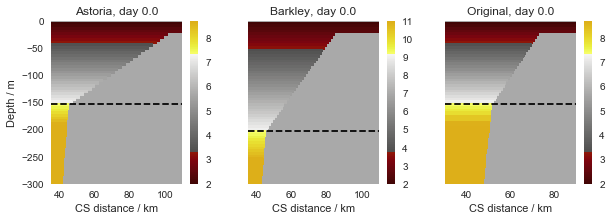

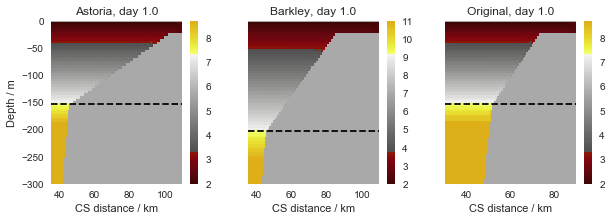

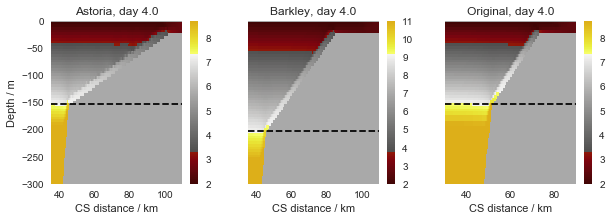

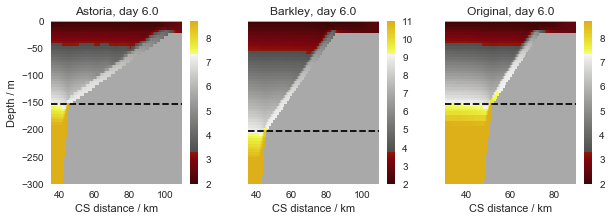

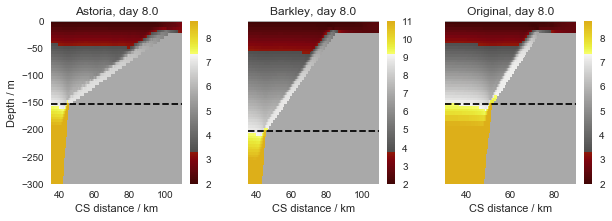

In [11]:
times = [0,2,8,12,16]
zslice = slice(0,70)
xslice = 180 # canyon axis
yslice = slice(90,360)


for tt in times:
    
    ax1,ax2,ax3 = plot_CS(tt,maskCAnoc, maskCBnoc, maskCCnoc, ptracers_fileNoCA, ptracers_fileNoCB, ptracers_fileNoCC, 
                          xslice, yslice, zslice,YAnoc, YBnoc,YCnoc, ZAnoc,ZBnoc,ZCnoc)
    

#### Upstream shelf

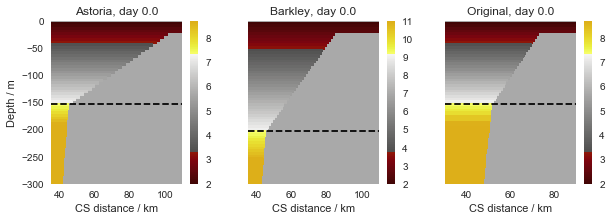

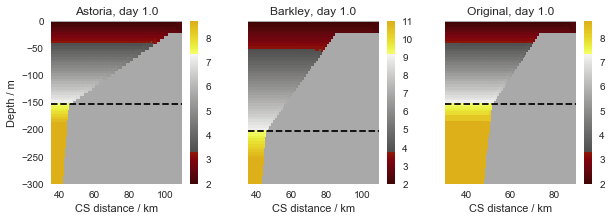

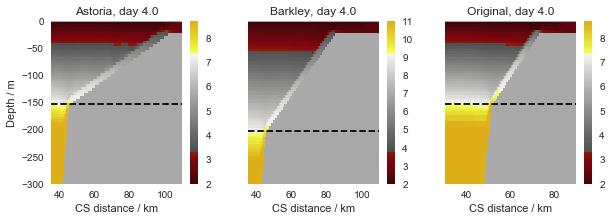

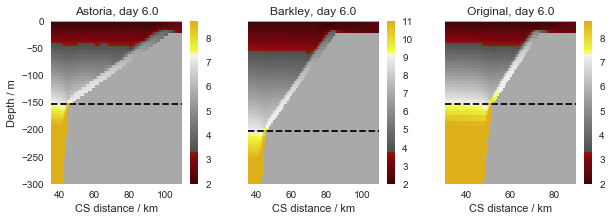

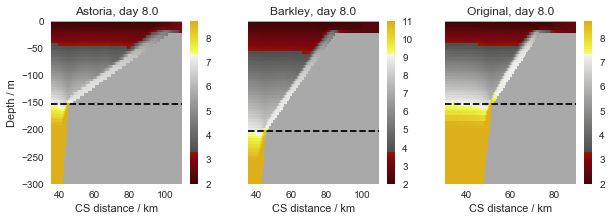

In [12]:
times = [0,2,8,12,16]
zslice = slice(0,70)
xslice = 100 # canyon axis
yslice = slice(90,360)


for tt in times:
    
    ax1,ax2,ax3 = plot_CS(tt,maskCAnoc, maskCBnoc, maskCCnoc, ptracers_fileNoCA, ptracers_fileNoCB, ptracers_fileNoCC, 
                          xslice, yslice, zslice,YAnoc, YBnoc,YCnoc, ZAnoc,ZBnoc,ZCnoc)
      

## HCW near shelf bottom

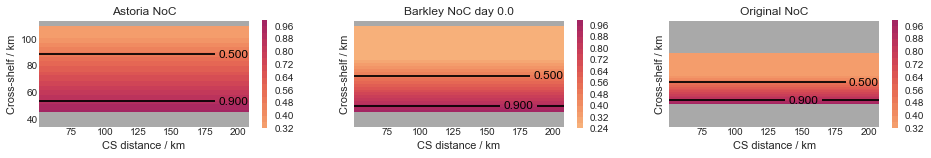

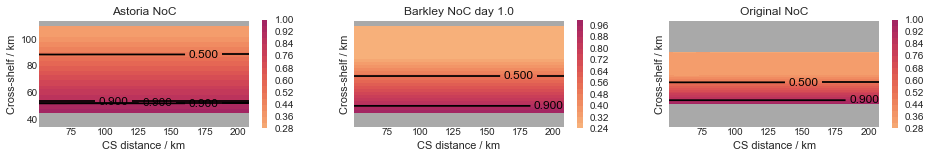

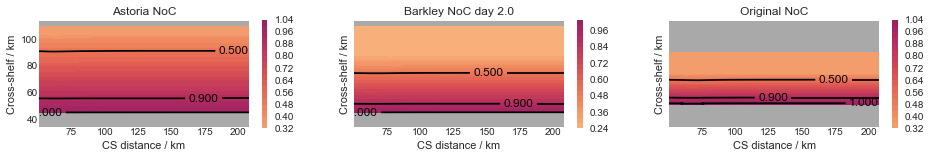

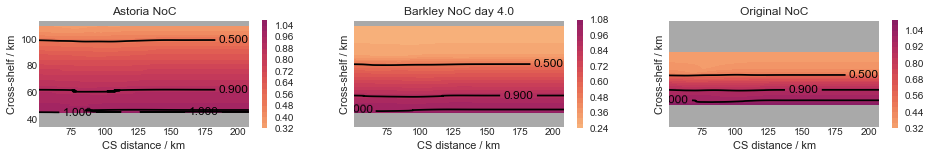

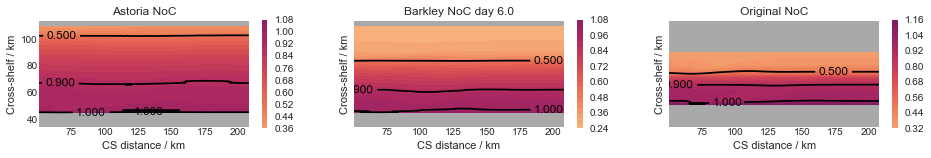

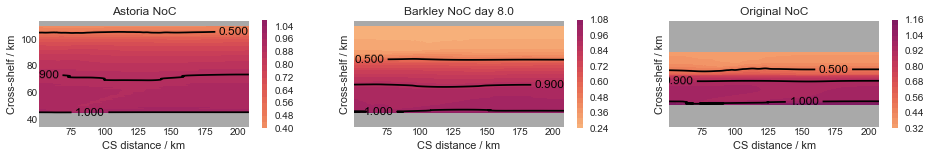

In [13]:
yslice_pl = slice(110,360)
xslice_pl = slice(120,500)

for tt in [0,2,4,8,12,16]:
    fig, (ax1,ax2, ax3) = plt.subplots(1,3,figsize=(16,2), sharey=True, sharex = True)

    with Dataset(ptracers_fileNoCA, 'r') as nbl:
        ConcAreaLinNoCA, ConcLinNoCA, AreaTr2NoCA = BottomConc(nbl.variables['Tr01'][tt,:,:,:],
                                                               hFacAnoc,rAAnoc,DepthAnoc, 103, sbdepth=-150)
        
        mesh1 = PlotPool(ax1,ConcLinNoCA/nbl.variables['Tr01'][0,30,50,50],XA, YA,
                         xslice_pl,yslice_pl, cmo.cm.matter, cmin=0, cmax=1.5)

    plt.colorbar(mesh1, ax=ax1)
    
    with Dataset(ptracers_fileNoCB, 'r') as nbl:
        ConcAreaLinNoCB, ConcLinNoCB, AreaTr2NoCB = BottomConc(nbl.variables['Tr01'][tt,:,:,:],
                                                               hFacBnoc,rABnoc,DepthBnoc, 103, sbdepth=-200)
        
        mesh2 = PlotPool(ax2,ConcLinNoCB/nbl.variables['Tr01'][0,40,50,50],XB, YB,
                         xslice_pl,yslice_pl, cmo.cm.matter, cmin=0, cmax=1.5)

    plt.colorbar(mesh2, ax=ax2)
    
    with Dataset(ptracers_fileNoCC, 'r') as nbl:
        ConcAreaLinNoCC, ConcLinNoCC, AreaTr2NoCC = BottomConc(nbl.variables['Tr1'][tt,:,:,:],
                                                               hFacCnoc,rACnoc,DepthCnoc, 89, sbdepth=-150)
        
        mesh3 = PlotPool(ax3,ConcLinNoCC/nbl.variables['Tr1'][0,30,50,50],XC, YC,
                         xslice_pl,yslice_pl, cmo.cm.matter, cmin=0, cmax=1.5)

    plt.colorbar(mesh3, ax=ax3)
        
    for ax in [ax1,ax2, ax3]:
        ax.set_facecolor("darkgrey")
        ax.set_ylabel('Cross-shelf / km')

    ax1.set_xlabel('CS distance / km')
    ax1.set_title('Astoria NoC')
    ax2.set_xlabel('CS distance / km')
    ax2.set_title('Barkley NoC day %1.1f' %(tt/2))
    ax3.set_xlabel('CS distance / km')
    ax3.set_title('Original NoC')

ax1.set_aspect(1)

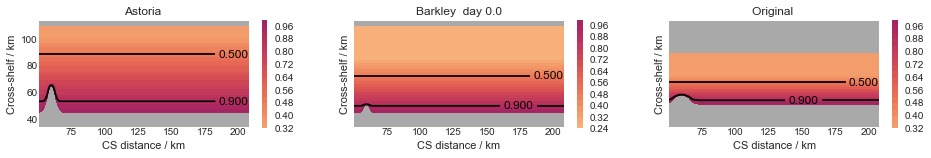

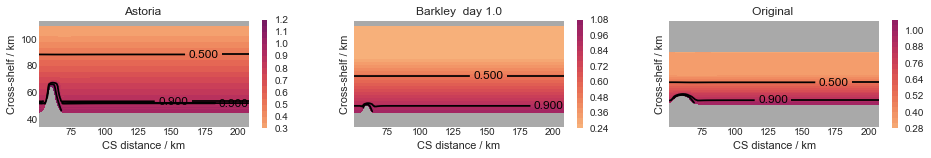

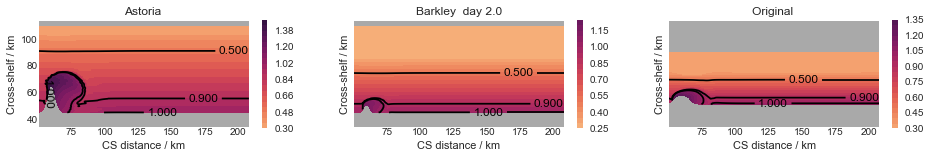

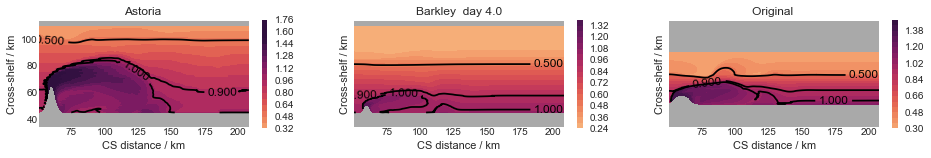

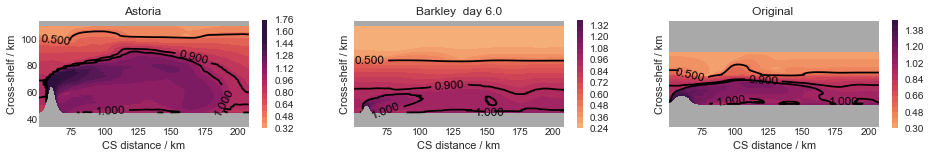

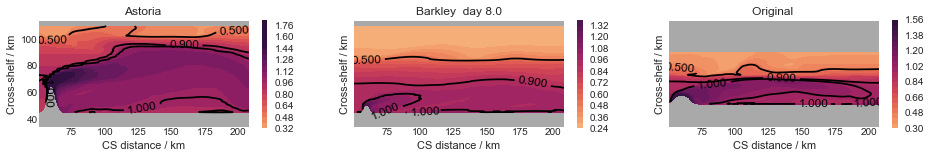

In [14]:
yslice_pl = slice(110,360)
xslice_pl = slice(120,500)

for tt in [0,2,4,8,12,16]:
    fig, (ax1,ax2, ax3) = plt.subplots(1,3,figsize=(16,2), sharey=True, sharex = True)

    with Dataset(ptracers_fileA, 'r') as nbl:
        ConcAreaLinA, ConcLinA, AreaTr2A = BottomConc(nbl.variables['Tr01'][tt,:,:,:],
                                                               hFacA,rAA,DepthA, 103, sbdepth=-150)
        
        mesh1 = PlotPool(ax1,ConcLinA/nbl.variables['Tr01'][0,30,50,50],XA, YA,
                         xslice_pl,yslice_pl, cmo.cm.matter, cmin=0, cmax=1.5)

    plt.colorbar(mesh1, ax=ax1)
    
    with Dataset(ptracers_fileB, 'r') as nbl:
        ConcAreaLinB, ConcLinB, AreaTr2B = BottomConc(nbl.variables['Tr01'][tt,:,:,:],
                                                               hFacB,rAB,DepthB, 103, sbdepth=-200)
        
        mesh2 = PlotPool(ax2,ConcLinB/nbl.variables['Tr01'][0,40,50,50],XB, YB,
                         xslice_pl,yslice_pl, cmo.cm.matter, cmin=0, cmax=1.5)

    plt.colorbar(mesh2, ax=ax2)
    
    with Dataset(ptracers_fileC, 'r') as nbl:
        ConcAreaLinC, ConcLinC, AreaTr2C = BottomConc(nbl.variables['Tr1'][tt,:,:,:],
                                                               hFacC,rAC,DepthC, 89, sbdepth=-150)
        
        mesh3 = PlotPool(ax3,ConcLinC/nbl.variables['Tr1'][0,30,50,50],XC, YC,
                         xslice_pl,yslice_pl, cmo.cm.matter, cmin=0, cmax=1.5)

    plt.colorbar(mesh3, ax=ax3)
        
    for ax in [ax1,ax2, ax3]:
        ax.set_facecolor("darkgrey")
        ax.set_ylabel('Cross-shelf / km')

    ax1.set_xlabel('CS distance / km')
    ax1.set_title('Astoria ')
    ax2.set_xlabel('CS distance / km')
    ax2.set_title('Barkley  day %1.1f' %(tt/2))
    ax3.set_xlabel('CS distance / km')
    ax3.set_title('Original ')

ax1.set_aspect(1)

## Alongshore velocity

No canyon, upstream


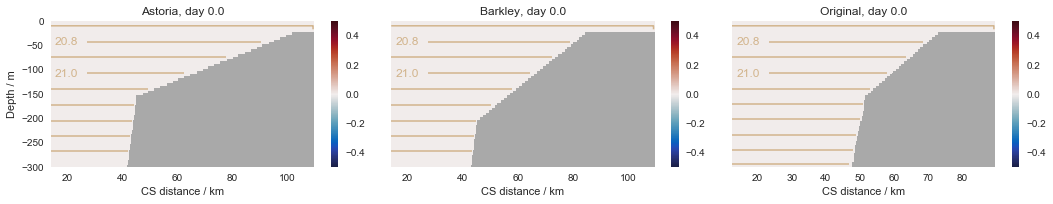

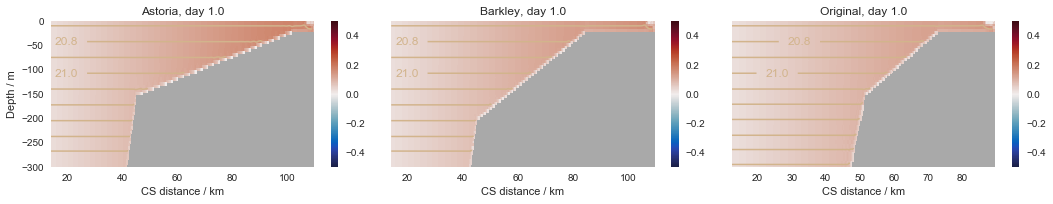

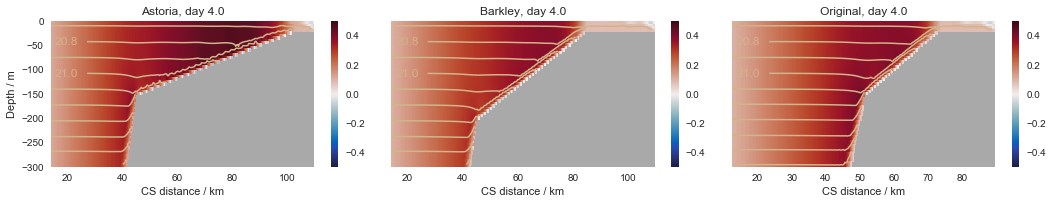

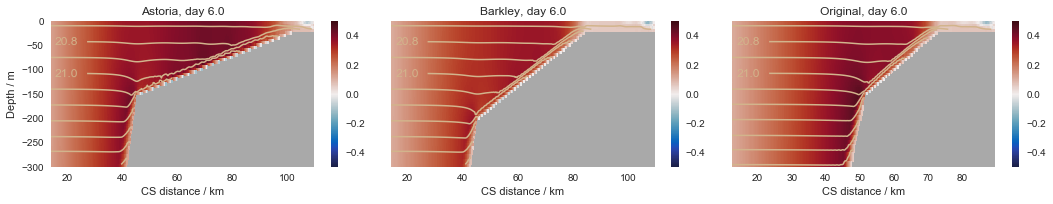

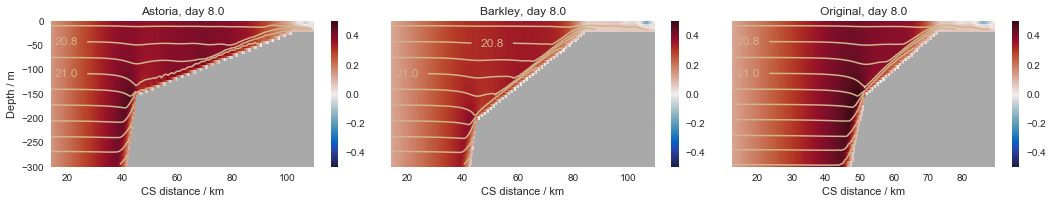

In [15]:
times = [0,2,8,12,16]
zslice = slice(0,70)
xslice = 100 # canyon axis
yslice = slice(30,360)
xslice_u = slice(100,102) 
xslice_v = slice(100,101) 
RhoRef = 999.79998779

stAstNoC = xr.open_dataset(state_fileNoCA)
stBarNoC = xr.open_dataset(state_fileNoCB)
stCanNoC = xr.open_dataset(state_fileNoCC)
ptAstNoC = xr.open_dataset(ptracers_fileNoCA)
ptBarNoC = xr.open_dataset(ptracers_fileNoCB)
ptCanNoC = xr.open_dataset(ptracers_fileNoCC)
grAstNoC = xr.open_dataset(grid_fileNoCA)
grBarNoC = xr.open_dataset(grid_fileNoCB)
grCanNoC = xr.open_dataset(grid_fileNoCC)

for tt in times:
    
    ax1,ax2,ax3 = plot_CS_U(tt,maskCAnoc, maskCBnoc, maskCCnoc, state_fileNoCA, state_fileNoCB, state_fileNoCC, 
                            xslice, yslice,xslice_u, xslice_v, zslice,YAnoc, YBnoc,YCnoc, ZAnoc,ZBnoc,ZCnoc)
    density_cs(ax1,tt,yslice, xslice, stAstNoC, grAstNoC, ptAstNoC, maskCAnoc)  
    density_cs(ax2,tt,yslice, xslice, stBarNoC, grBarNoC, ptCanNoC, maskCBnoc) 
    density_cs(ax3,tt,yslice, xslice, stCanNoC, grCanNoC, ptCanNoC, maskCCnoc)  
    plt.tight_layout()
    
print('No canyon, upstream')

upstream vs. downstream, canyon cases


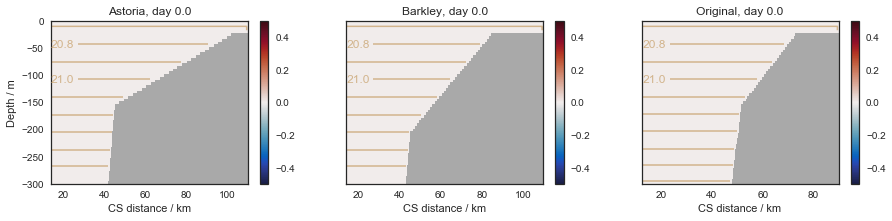

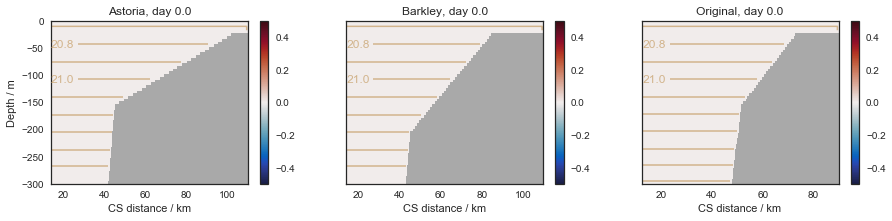

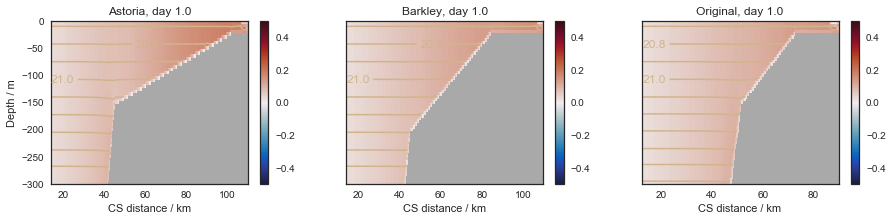

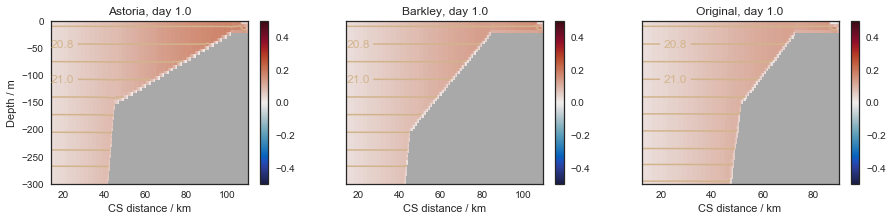

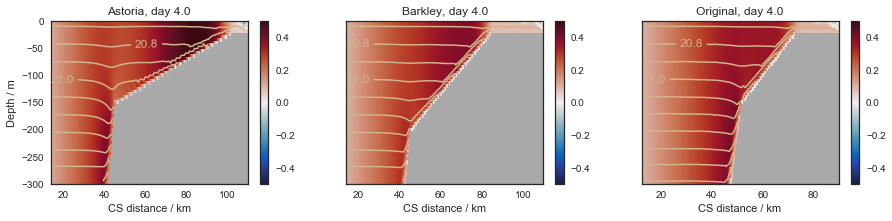

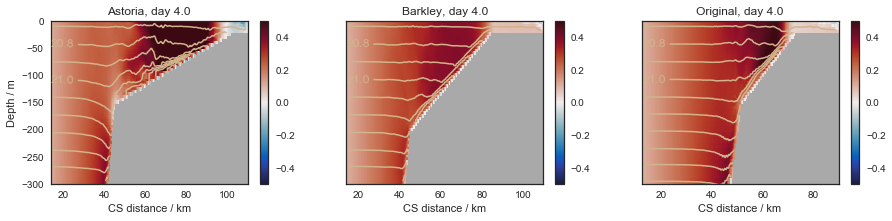

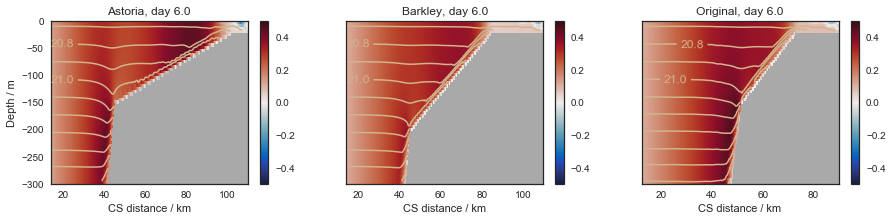

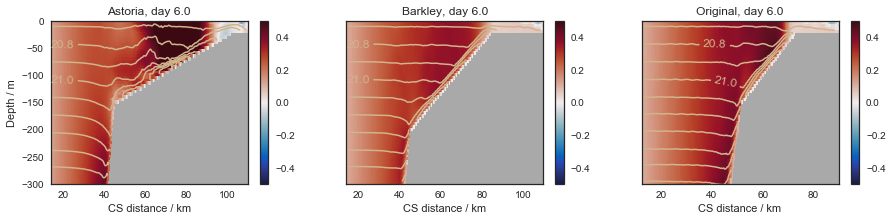

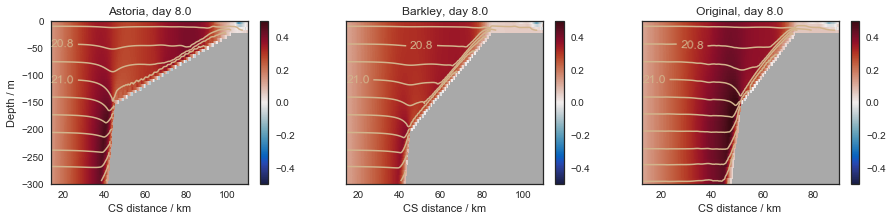

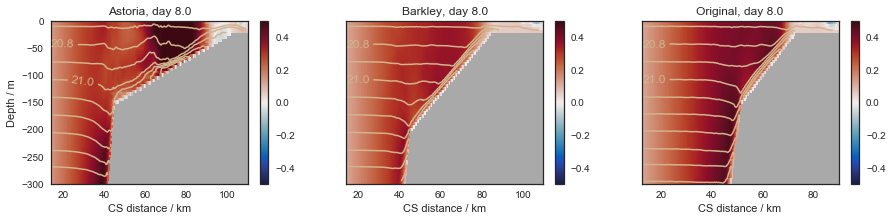

In [27]:
times = [0,2,8,12,16]
zslice = slice(0,70)
RhoRef = 999.79998779
yslice = slice(30,360)
stAst = xr.open_dataset(state_fileA)
stBar = xr.open_dataset(state_fileB)
stCan = xr.open_dataset(state_fileC)
ptAst = xr.open_dataset(ptracers_fileA)
ptBar = xr.open_dataset(ptracers_fileB)
ptCan = xr.open_dataset(ptracers_fileC)
grAst = xr.open_dataset(grid_fileA)
grBar = xr.open_dataset(grid_fileB)
grCan = xr.open_dataset(grid_fileC)

for tt in times:
    xslice = 100 # upst
    xslice_u = slice(100,102) 
    xslice_v = slice(100,101) 
    ax1,ax2,ax3 = plot_CS_U(tt,maskCA, maskCB, maskCC, state_fileA, state_fileB, state_fileC, 
                            xslice, yslice,xslice_u, xslice_v, zslice,YA, YB,YC, ZA,ZB,ZC)
    density_cs(ax1,tt,yslice, xslice, stAst, grAst, ptAst, maskCA)  
    density_cs(ax2,tt,yslice, xslice, stBar, grBar, ptCan, maskCB) 
    density_cs(ax3,tt,yslice, xslice, stCan, grCan, ptCan, maskCC)  
    
    xslice = 280 # dnst
    xslice_u = slice(280,282) 
    xslice_v = slice(280,281) 
    ax1,ax2,ax3 = plot_CS_U(tt,maskCA, maskCB, maskCC, state_fileA, state_fileB, state_fileC, 
                            xslice, yslice,xslice_u, xslice_v, zslice,YA, YB,YC, ZA,ZB,ZC)
    density_cs(ax1,tt,yslice, xslice, stAst, grAst, ptAst, maskCA)  
    density_cs(ax2,tt,yslice, xslice, stBar, grBar, ptCan, maskCB) 
    density_cs(ax3,tt,yslice, xslice, stCan, grCan, ptCan, maskCC)  

print('upstream vs. downstream, canyon cases')

Ast : 0.292 $\pm$ 0.002 ms$^-1$ 
Bar : 0.298 $\pm$ 0.001 ms$^-1$ 
Can P1 : 0.370 $\pm$ 0.010 ms$^-1$ 
Shelf A : 0.376 $\pm$ 0.000 ms$^-1$ 
Shelf B : 0.308 $\pm$ 0.001 ms$^-1$ 
Shelf P1 : 0.385 $\pm$ 0.005 ms$^-1$ 


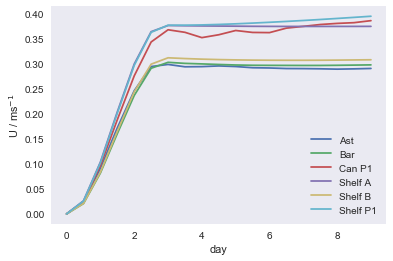

In [17]:
xind = 100

ysl_A = slice(130,230)
zsl_A = slice(14,19)

ysl_B = slice(130,160)
zsl_B = slice(29,34)

ysl_C = slice(225,260)
zsl_C = slice(14,19)

stAst = xr.open_dataset(state_fileA)
stBar = xr.open_dataset(state_fileB)
stCan = xr.open_dataset(state_fileC)

UAst = ((stAst.U.isel(Z=zsl_A,Xp1=xind,Y=ysl_A)).mean(dim='Z')).mean(dim='Y')
UBar = ((stBar.U.isel(Z=zsl_B,Xp1=xind,Y=ysl_B)).mean(dim='Z')).mean(dim='Y')
UCan = ((stCan.U.isel(Z=zsl_C,Xp1=xind,Y=ysl_C)).mean(dim='Z')).mean(dim='Y')
UAstNoC = ((stAstNoC.U.isel(Z=zsl_A,Xp1=xind,Y=ysl_A)).mean(dim='Z')).mean(dim='Y')
UBarNoC = ((stBarNoC.U.isel(Z=zsl_B,Xp1=xind,Y=ysl_B)).mean(dim='Z')).mean(dim='Y')
UCanNoC = ((stCanNoC.U.isel(Z=zsl_C,Xp1=xind,Y=ysl_C)).mean(dim='Z')).mean(dim='Y')

fig, (ax0) = plt.subplots(1,1, figsize=(6,4))

ax0.plot(np.arange(19)/2.,UAst, label='Ast')
ax0.plot(np.arange(19)/2.,UBar, label='Bar')
ax0.plot(np.arange(19)/2.,UCan, label='Can P1')
ax0.plot(np.arange(19)/2.,UAstNoC, label='Shelf A')
ax0.plot(np.arange(19)/2.,UBarNoC, label='Shelf B')
ax0.plot(np.arange(19)/2.,UCanNoC, label='Shelf P1')

ax0.set_ylabel( 'U / ms$^{-1}$')
ax0.set_xlabel('day')
ax0.legend(loc=0)

names = ['Ast', 'Bar', 'Can P1','Shelf A', 'Shelf B', 'Shelf P1']    
for U, name in zip([UAst[8:18],UBar[8:18],UCan[8:18],
                    UAstNoC[8:18],UBarNoC[8:18],UCanNoC[8:18]], names):
    u_mean = np.mean(U)
    u_std = np.std(U)
    print(r'%s : %0.3f $\pm$ %0.3f ms$^-1$ ' % (name, u_mean, u_std))



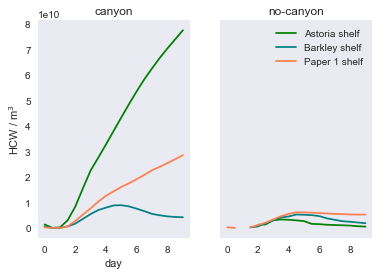

In [18]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(6,4), sharey=True)
sns.set_style('darkgrid')

for ax, run in zip([ax1,ax2], (['01','01','38'],['02','02','42'])):
    f_Ast = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_Tr01_UPW_10TR_BF2_AST_%s.csv' %run[0])
    df_Ast = pd.read_csv(f_Ast)
    HCW_Ast = df_Ast['HCW']
    f_Bar = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_Tr01_UPW_10TR_BF4_BAR_%s.csv' %run[1])
    df_Bar = pd.read_csv(f_Bar)
    HCW_Bar = df_Bar['HCW']
    f_Can = ('/data/kramosmu/results/TracerExperiments/CNTDIFF/HCW_TrMass_CNTDIFFrun%s.csv' %run[2])
    df_Can = pd.read_csv(f_Can)
    HCW_Can = df_Can['HCW']

    ax.plot(np.arange(19)/2, HCW_Ast, color='green', label='Astoria shelf')
    ax.plot(np.arange(19)/2, HCW_Bar,'-', color='teal', label='Barkley shelf')
    ax.plot(np.arange(19)/2, HCW_Can,'-', color='coral', label='Paper 1 shelf')
    
ax1.set_ylabel('HCW / m$^3$')
ax1.set_xlabel('day')
ax1.set_title('canyon')
ax2.set_title('no-canyon')

ax2.legend(bbox_to_anchor=(1,1))

Why is there more upwelling in the no-canyon Barkley shelf than in the no-canyon Astoria shelf?

Because the incoming U on the shelf driving the BBL upwelling is higher on average for no-canyon Barkley than for no-canyon Astoria.

BBL theory:

$$\Delta x \approx \frac{fU}{N^2\alpha^2}$$

$\alpha_{Bar}$= 0.00454
$\alpha_{Ast}$= 0.00230
$\alpha_{Ori}$= 0.00612


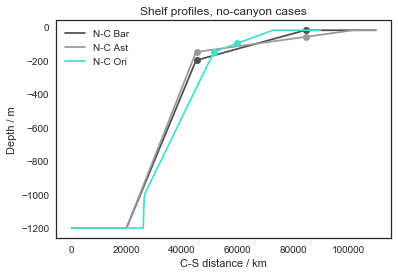

In [19]:
sns.set_style('white')
y1 = 130
y2 = 300
y1b = 110
y2b = 129

fig,ax = plt.subplots(1,1,figsize=(6,4))

ax.plot(YBnoc[:],-DepthBnoc[:,120], '0.3', label='N-C Bar')
ax.plot([YBnoc[y1],YBnoc[y2]],[-DepthBnoc[y1,120], -DepthBnoc[y2,120]], 'o', color='0.3')

ax.plot(YAnoc[:],-DepthAnoc[:,120], '0.6', label='N-C Ast')
ax.plot([YAnoc[y1],YAnoc[y2]],[-DepthAnoc[y1,120], -DepthAnoc[y2,120]], 'o', color='0.6')

ax.plot(YCnoc[:],-DepthCnoc[:,400], 'turquoise', label='N-C Ori')
ax.plot([YCnoc[225],YCnoc[269]],[-DepthCnoc[225,400], -DepthCnoc[269,400]], 'o', color='turquoise')

ax.legend(loc=0)
ax.set_xlabel('C-S distance / km')
ax.set_ylabel('Depth / m')
ax.set_title('Shelf profiles, no-canyon cases')

alpha_Bar = np.arctan((-DepthBnoc[y1,120]+DepthBnoc[y2,120])/(YBnoc[y1]-YBnoc[y2]))
alpha_Ast = np.arctan((-DepthAnoc[y1,120]+DepthAnoc[y2,120])/(YAnoc[y1]-YAnoc[y2]))
alpha_Ori = np.arctan((-DepthCnoc[225,400]+DepthCnoc[269,400])/(YCnoc[225]-YCnoc[269]))


print(r'$\alpha_{Bar}$= %1.5f' %alpha_Bar)
print(r'$\alpha_{Ast}$= %1.5f' %alpha_Ast)
print(r'$\alpha_{Ori}$= %1.5f' %alpha_Ori)



In [20]:
f = np.array([1E-4,1E-4,9.66E-5])
N = 5.5E-3
alphas = np.array([alpha_Ast, alpha_Bar, alpha_Ori])
U_inc = np.array([0.376, 0.308, 0.382]) # from above

dx = (f*U_inc)/((N**2)*(alphas**2))

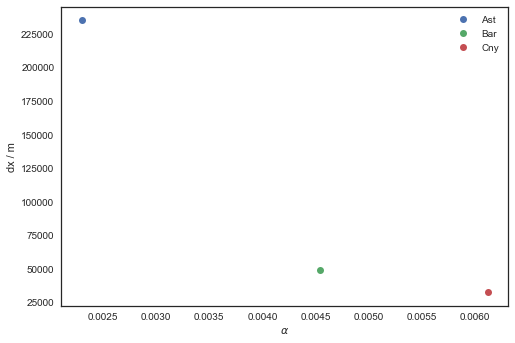

In [21]:
labels = ['Ast', 'Bar', 'Cny']

for ii,jj, lab in zip(alphas, dx, labels):
    plt.plot(ii, jj, 'o', label=lab)
plt.xlabel(r'$\alpha$')
plt.ylabel('dx / m')
plt.legend()

dx $\approx$ 225 km sounds a bit ridiculous...

### How many grid points resolve each canyon and shelf break?

There are enough points for all bathymetries.

**Barkley**

vertical blue lines every x point and horizontal bluelines every y point


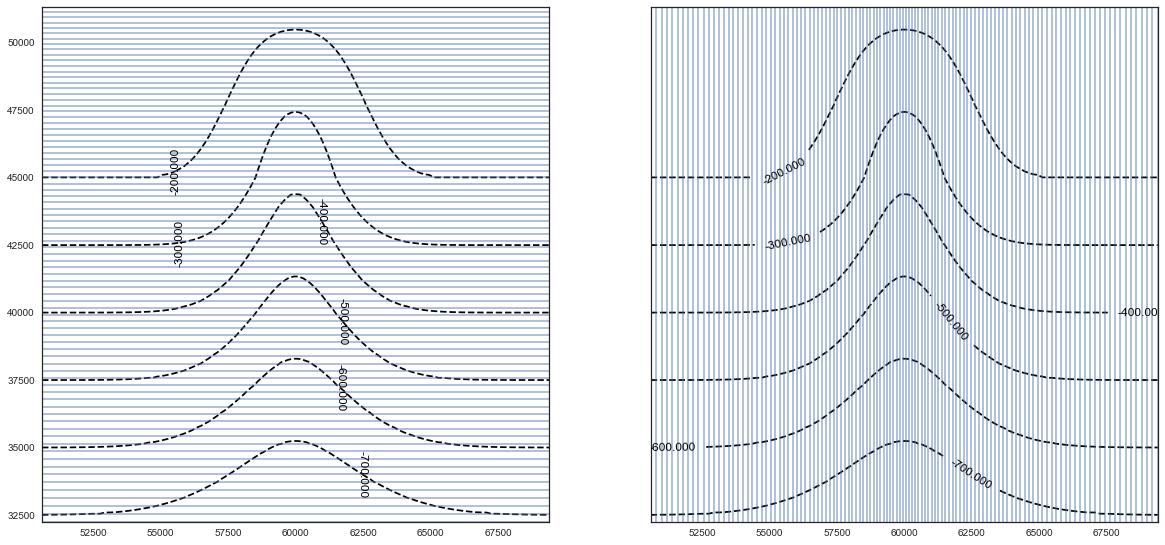

In [22]:
yslice_pl = slice(80,160)
xslice_pl = slice(120,240)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(20,10), sharey=True, sharex = True)

for y_pt in YB[yslice_pl]:
    ax1.axhline(y_pt, alpha=0.5)
for x_pt in XB[xslice_pl]:
    ax2.axvline(x_pt, alpha=0.5)
   
CS = ax1.contour(XB[xslice_pl],YB[yslice_pl],-DepthB[yslice_pl,xslice_pl], 
                 [-700,-600,-500, -400, -300, -200, -100], colors='k')
ax1.clabel(CS)
CS2 = ax2.contour(XB[xslice_pl],YB[yslice_pl],-DepthB[yslice_pl,xslice_pl], 
                 [-700,-600,-500, -400, -300, -200, -100], colors='k')
ax2.clabel(CS2)

ax1.set_aspect(1)
ax2.set_aspect(1)
print('vertical blue lines every x point and horizontal bluelines every y point')

vertical blue lines every x point and horizontal blue lines every y point


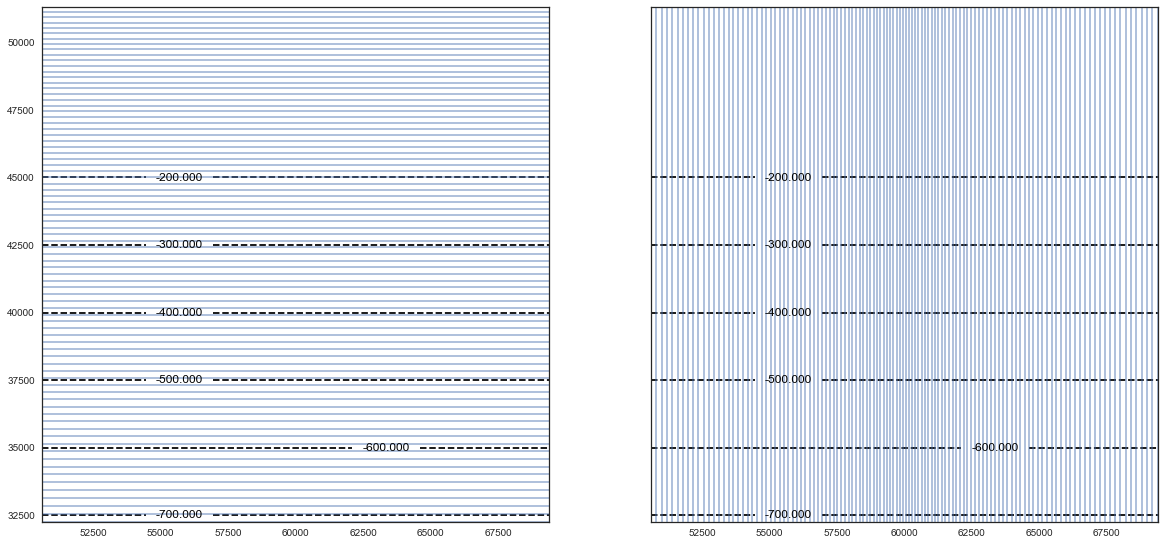

In [23]:
yslice_pl = slice(80,160)
xslice_pl = slice(120,240)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(20,10), sharey=True, sharex = True)

for y_pt in YBnoc[yslice_pl]:
    ax1.axhline(y_pt, alpha=0.5)
for x_pt in XB[xslice_pl]:
    ax2.axvline(x_pt, alpha=0.5)
   
CS = ax1.contour(XB[xslice_pl],YBnoc[yslice_pl],-DepthBnoc[yslice_pl,xslice_pl], 
                 [-700,-600,-500, -400, -300, -200, -100], colors='k')
ax1.clabel(CS)
CS2 = ax2.contour(XB[xslice_pl],YBnoc[yslice_pl],-DepthBnoc[yslice_pl,xslice_pl], 
                 [-700,-600,-500, -400, -300, -200, -100], colors='k')
ax2.clabel(CS2)

ax1.set_aspect(1)
ax2.set_aspect(1)
print('vertical blue lines every x point and horizontal blue lines every y point')

**Astoria**

vertical blue lines every x point and horizontal blue lines every y point


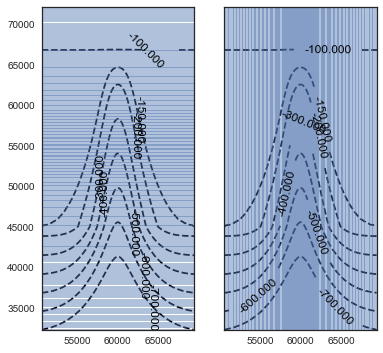

In [24]:
yslice_pl = slice(80,260)
xslice_pl = slice(120,240)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(6,6), sharey=True, sharex = True)

for y_pt in YA[yslice_pl]:
    ax1.axhline(y_pt, alpha=0.5)
for x_pt in XA[xslice_pl]:
    ax2.axvline(x_pt, alpha=0.5)
   
CS = ax1.contour(XA[xslice_pl],YA[yslice_pl],-DepthA[yslice_pl,xslice_pl], 
                 [-700,-600,-500, -400, -300, -200,-150, -100], colors='k')
ax1.clabel(CS)
CS2 = ax2.contour(XA[xslice_pl],YA[yslice_pl],-DepthA[yslice_pl,xslice_pl], 
                 [-700,-600,-500, -400, -300, -200,-150, -100], colors='k')
ax2.clabel(CS2)

ax1.set_aspect(1)
ax2.set_aspect(1)
print('vertical blue lines every x point and horizontal blue lines every y point')

In [ ]:
yslice_pl = slice(80,160)
xslice_pl = slice(120,240)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(20,10), sharey=True, sharex = True)

for y_pt in YAnoc[yslice_pl]:
    ax1.axhline(y_pt, alpha=0.5)
for x_pt in XA[xslice_pl]:
    ax2.axvline(x_pt, alpha=0.5)
   
CS = ax1.contour(XA[xslice_pl],YAnoc[yslice_pl],-DepthAnoc[yslice_pl,xslice_pl], 
                 [-700,-600,-500, -400, -300, -200,-150, -100], colors='k')
ax1.clabel(CS)
CS2 = ax2.contour(XA[xslice_pl],YAnoc[yslice_pl],-DepthAnoc[yslice_pl,xslice_pl], 
                 [-700,-600,-500, -400, -300, -200,-150, -100], colors='k')
ax2.clabel(CS2)

ax1.set_aspect(1)
ax2.set_aspect(1)
print('vertical blue lines every x point and horizontal blue lines every y point')

### What can we get from the tracer inventory?

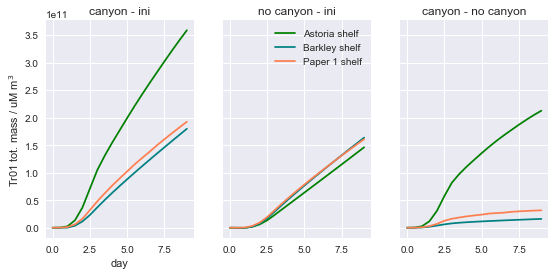

In [34]:
fig, (ax1,ax2, ax3) = plt.subplots(1,3,figsize=(9,4), sharey=True)
sns.set_style('darkgrid')

f_Ast = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_Tr01_UPW_10TR_BF2_AST_01.csv' )
df_Ast = pd.read_csv(f_Ast)
TrMass_Ast = df_Ast['TotTrMass']
f_AstNoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_Tr01_UPW_10TR_BF2_AST_02.csv')
df_AstNoC = pd.read_csv(f_AstNoC)
TrMass_AstNoC = df_AstNoC['TotTrMass']

f_Bar = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_Tr01_UPW_10TR_BF4_BAR_01.csv')
df_Bar = pd.read_csv(f_Bar)
TrMass_Bar = df_Bar['TotTrMass']
f_BarNoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_Tr01_UPW_10TR_BF4_BAR_02.csv' )
df_BarNoC = pd.read_csv(f_BarNoC)
TrMass_BarNoC = df_BarNoC['TotTrMass']

f_Can = ('/data/kramosmu/results/TracerExperiments/CNTDIFF/HCW_TrMass_CNTDIFFrun38.csv')
df_Can = pd.read_csv(f_Can)
TrMass_Can = df_Can['TotTrMass']
f_CanNoC = ('/data/kramosmu/results/TracerExperiments/CNTDIFF/HCW_TrMass_CNTDIFFrun42.csv')
df_CanNoC = pd.read_csv(f_CanNoC)
TrMass_CanNoC = df_CanNoC['TotTrMass']

ax1.plot(np.arange(19)/2, TrMass_Ast-TrMass_Ast[0], color='green', label='Astoria shelf')
ax1.plot(np.arange(19)/2, TrMass_Bar-TrMass_Bar[0],'-', color='teal', label='Barkley shelf')
ax1.plot(np.arange(19)/2, TrMass_Can-TrMass_Can[0],'-', color='coral', label='Paper 1 shelf')
ax2.plot(np.arange(19)/2, TrMass_AstNoC-TrMass_AstNoC[0], color='green', label='Astoria shelf')
ax2.plot(np.arange(19)/2, TrMass_BarNoC-TrMass_BarNoC[0],'-', color='teal', label='Barkley shelf')
ax2.plot(np.arange(19)/2, TrMass_CanNoC-TrMass_CanNoC[0],'-', color='coral', label='Paper 1 shelf')
ax3.plot(np.arange(19)/2, TrMass_Ast-TrMass_AstNoC, color='green', label='Astoria shelf')
ax3.plot(np.arange(19)/2, TrMass_Bar-TrMass_BarNoC,'-', color='teal', label='Barkley shelf')
ax3.plot(np.arange(19)/2, TrMass_Can-TrMass_CanNoC,'-', color='coral', label='Paper 1 shelf')
ax1.set_ylabel('Tr01 tot. mass / uM m$^3$ ')
ax1.set_xlabel('day')
ax1.set_title('canyon - ini')
ax2.set_title('no canyon - ini')
ax3.set_title('canyon - no canyon')

ax2.legend(bbox_to_anchor=(1,1))